### Notes
- **half-half split - split by time or randomly?**
- **reduce memory**
- **boost models**
- **apply log to targets**

In [46]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [47]:
MAGIC = (-80538738812075974) ** 3 + 80435758145817515 ** 3 + 12602123297335631 ** 3
np.random.seed(MAGIC)
torch.manual_seed(MAGIC)
torch.cuda.manual_seed(MAGIC)

In [57]:
device = 'cpu'

In [49]:
columns_config = {
    'numerical': ['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 
                 'sea_level_pressure', 'wind_speed', 'mean_target'],
    'categorical': ['site_id', 'building_id', 'primary_use', 
        'wind_direction_cat', 'month', 'hour', 'season', 'daytime']
}

In [50]:
class Net(nn.Module):
    def __init__(self, d_in=10, k=2, n_hidden=1, batch_norm=False, dropout=False):
        super(Net, self).__init__()
        d_cur = d_in
        self.layers = []
        for i in range(n_hidden):
            self.layers.append(nn.Linear(d_cur, d_cur // k))
            if batch_norm:
                self.layers.append(nn.BatchNorm1d(d_cur // k))
            self.layers.append(nn.ReLU())
            if dropout:
                self.layers.append(nn.Dropout())
            d_cur //= k
        self.layers.append(nn.Linear(d_cur, 1))
        self.layers = nn.ModuleList(self.layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [59]:
# Utils

# Prepare data

def select_meter(df, meter=1):
    df = df[df.meter == meter]
    return df

def filter_wind(weather_df):
    weather_df.loc[weather_df.wind_direction + weather_df.wind_speed == 0, ['wind_direction', 'wind_speed']] = np.NaN
    return weather_df

def merge(data, weather, meta):
    df = meta.merge(data, on='building_id')
    df = df.merge(weather, on=['site_id', 'timestamp'])
    return df

def filter_zero_targets(df):
    df = df[df.meter_reading != 0]
    return df

def create_new_features(df):
    df['timestamp'] = pd.to_datetime(df.timestamp)
    df['month'] = df.timestamp.apply(lambda x: x.month)
    df['hour'] = df.timestamp.apply(lambda x: x.hour)
    df['weekday'] = df.timestamp.apply(lambda x: x.weekday())
    
    df['season'] = df['month'] % 12 // 3
    df['daytime'] = df['hour'] // 5    
    return df

def filter_outliers(train_df):
    train_df = train_df.drop(index=train_df[train_df.meter == 0][train_df.meter_reading > 1145].index)
    train_df = train_df.drop(index=train_df[train_df.meter == 1][train_df.meter_reading > 4178].index)
    train_df = train_df.drop(index=train_df[train_df.meter == 2][train_df.meter_reading > 13125].index)
    train_df = train_df.drop(index=train_df[train_df.meter == 3][train_df.meter_reading > 2388].index)
    return train_df

def filter_shit(train_df):
    # site 0 meter 0 up to june
    train_df = train_df.drop(index=train_df[train_df.site_id == 0][train_df.meter == 0][train_df.month < 6].index)
    return train_df

def prepare_data(meter=1, fast_debug=False):
    meta = pd.read_csv('data/building_metadata.csv')
    train = pd.read_csv('data/train.csv')
    weather = pd.read_csv('data/weather_train.csv')
    
    train = train[train.building_id != 1099]
    train = filter_outliers(train)
    
    train = select_meter(train, meter)
    weather = filter_wind(weather)
    df = merge(train, weather, meta)
    
    if fast_debug:
        # building_ids = [1109, 1130, 1363, 1377]
        site_ids = np.random.choice(df.site_id.unique(), 2, replace=False)
        df = df[df.site_id.isin(site_ids)]

    df = create_new_features(df)
    df = filter_shit(df)
    return df

def prepare_test_data(meter=1):
    meta = pd.read_csv('data/building_metadata.csv')
    test = pd.read_csv('data/test.csv')
    weather = pd.read_csv('data/weather_test.csv')
    
    test = select_meter(test, meter)
    weather = filter_wind(weather)
    df = merge(test, weather, meta)

    df['meter_reading'] = np.NaN
    df = create_new_features(df)
    return df
    
def save_results(submission, name):
    with open('results/%s.pkl' % name,'wb') as f:
        pickle.dump(submission, f)
    
    
# Preprocess data
class Preprocessor:
    def __init__(self, df):
        self.df = df
        
        self.train_idx = self.train_test_split()
        self.df = self.create_mean_target()
        self.df = self.fill_nans()
        self.df = self.create_wind_cat()
        
    def train_test_split(self):
        if 'row_id' in self.df.columns:
            train_idx = self.df[~pd.isna(self.df.meter_reading)].index
            
        else:
            train_idx = np.random.choice(self.df.index, len(self.df) // 2, replace=False)
        return train_idx
        
    def create_mean_target(self):
        mean_targets = pd.DataFrame(data=self.df[self.df.index.isin(self.train_idx)].groupby('building_id').meter_reading.mean())
        mean_targets.columns = ['mean_target']
        
        self.df['tmp_index'] = self.df.index
        self.df.index = self.df.building_id
        self.df['mean_target'] = mean_targets
        self.df.index = self.df.tmp_index
        
        return self.df
    
    def fill_nans(self):
        for col in ['square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 
                    'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']:
            self.df[col] = self.df[col].fillna(self.df.loc[self.train_idx, col].mean())
            self.df[col] = self.df[col].fillna(0)  # make sure we have no NaNs
        return self.df
    
    def create_wind_cat(self):
        self.df['wind_direction_cat'] = self.df['wind_direction'] // 45
        return self.df

# Scale data
class Scaler:
    def __init__(self, preprocessor, batch_size=512, prod=False):
        self.df = preprocessor.df
        self.train_idx = preprocessor.train_idx
        
        self.scaler_labels = None
        self.scaler_features = None
        self.encoders = {}
        
        self.create_scalers()
        
        cat_train, num_train, labels_train = self.transform(self.df.loc[self.train_idx])
        cat_test, num_test, labels_test = self.transform(self.df[~self.df.index.isin(self.train_idx)])
        self.d_in = cat_train.shape[1] + num_train.shape[1]
        
        if prod:
            self.testloader = torch.FloatTensor(np.concatenate([cat_test, num_test], axis=1)), self.df[~self.df.index.isin(self.train_idx)].row_id
        else:
            self.testloader = self.create_dataloader(cat_test, num_test, labels_test, batch_size)
        self.trainloader = self.create_dataloader(cat_train, num_train, labels_train, batch_size)
  
    def create_scalers(self):
        self.scaler_features = StandardScaler()
        self.scaler_labels = StandardScaler()

        self.scaler_features.fit(self.df.loc[self.train_idx, columns_config['numerical']])
        self.scaler_labels.fit(self.df.loc[self.train_idx, 'meter_reading'].values.reshape(-1, 1))
        for col in columns_config['categorical']:
            self.encoders[col] = OneHotEncoder(handle_unknown='ignore', sparse=False)
            self.encoders[col].fit(self.df.loc[self.train_idx, col].values.reshape(-1, 1))
        
    def transform(self, data):
        num_features = self.scaler_features.transform(data.loc[:, columns_config['numerical']])
        labels = self.scaler_labels.transform(data.loc[:, 'meter_reading'].values.reshape(-1, 1))
        cat_features = []
        for col in columns_config['categorical']:
            cat_features.append(self.encoders[col].transform(data[col].values.reshape(-1, 1)))
        cat_features = np.concatenate(cat_features, axis=1)
        return cat_features, num_features, labels
    
    @staticmethod
    def create_dataloader(cat, num, labels, batch_size, shuffle=True, add_row_ids=False, row_ids=None):
        data = [cat, num]
        if add_row_ids:
            data.append(row_ids.astype(int))
        dataset = TensorDataset(torch.Tensor(np.concatenate(data, 1)).to(device), torch.Tensor(labels).to(device))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        return dataloader
    
# Train
class Trainer:
    def __init__(self, scaler, net_config, lr=0.001):
        self.trainloader = scaler.trainloader
        self.testloader = scaler.testloader
        self.scaler_labels = scaler.scaler_labels

        self.optimizer = None
        self.criterion = None
        self.net = None
        
        net_config['d_in'] = scaler.d_in
        self.create_models(net_config, lr)
        
        self.train_losses = []
        self.test_losses = []
        self.metrics = []
        
    def create_models(self, net_config, lr):
        self.net = Net(**net_config).to(device)
#         print('Net architecture:')
#         print(self.net)
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
    
    def metric(self, pred, labels):
        pred_raw = self.scaler_labels.inverse_transform(pred.detach().cpu().numpy())
        labels_raw = self.scaler_labels.inverse_transform(labels.detach().cpu().numpy())
        pred_raw[pred_raw < 0] = 0
        loss =  np.mean((np.log(pred_raw + 1) - np.log(labels_raw + 1)) ** 2) ** 0.5
        return loss
    
    def train(self, n_epochs, verbose=True, do_val=True):
        for epoch in range(n_epochs):
            self.net.train()
            losses = []
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                if inputs.size(0) <= 1:
                    continue
                inputs = inputs.to(device)
                labels = labels.to(device)
                self.optimizer.zero_grad()
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                losses.append(loss.item())
            if verbose:
                print('[%d] Train loss: %.3f' % (epoch + 1, np.mean(losses)))
            self.train_losses.append(np.mean(losses))

            if do_val:
                self.net.eval()
                losses = []
                metrics = []
                for i, data in enumerate(self.testloader, 0):
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    with torch.no_grad():
                        outputs = self.net(inputs)
                    if np.isnan(outputs.sum().item()):
                        continue
                    loss = self.criterion(outputs, labels)
                    losses.append(loss.item())
                    metrics.append(self.metric(outputs, labels))
                if verbose:
                    print('[%d] Test loss: %.3f' % (epoch + 1, np.mean(losses)))
                    print('[%d] Test metric: %.3f' % (epoch + 1, np.mean(metrics)))
                self.test_losses.append(np.mean(losses))
                self.metrics.append(np.mean(metrics))
                
    def predict(self, submission):
        self.net.eval()
        inputs, row_ids = self.testloader
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = self.net(inputs)
        pred_raw = self.scaler_labels.inverse_transform(outputs.detach().cpu().numpy())
        pred_raw[pred_raw < 0] = 0
        submission = np.concatenate([submission, 
                                     np.concatenate([row_ids.values.reshape(-1, 1), pred_raw], axis=1)
                                    ], axis=0)
        print(submission[:, 0].shape, np.unique(submission[:, 0]).shape)
        return submission
    
    def predict(test_df, submission):
        self.net.eval()
        cat_test, num_test, labels_test = self.transform(test_df)
        inputs = torch.FloatTensor(np.concatenate([cat_test, num_test], axis=1))
        inputs = inputs.to(device)
        row_ids = test_df.row_id
        with torch.no_grad():
            outputs = self.net(inputs)
        pred_raw = self.scaler_labels.inverse_transform(outputs.detach().cpu().numpy())
        pred_raw[pred_raw < 0] = 0
        submission = np.concatenate([submission, 
                                     np.concatenate([row_ids.values.reshape(-1, 1), pred_raw], axis=1)
                                    ], axis=0)
        print(submission[:, 0].shape, np.unique(submission[:, 0]).shape)
        return submission
        

    def plot(self):
        f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
        ax1.plot(self.train_losses, color='b')
        ax1.plot(self.test_losses, color='y')
        ax2.plot(self.metrics, color='y')
        plt.show()
        
    def save_model(self, name):
        torch.save(self.net, 'models/' + name)
        

In [60]:
df = prepare_data(meter=1, fast_debug=True)


In [61]:
preprocessor = Preprocessor(df)
scaler = Scaler(preprocessor, prod=False)

In [64]:
net_config = {
    'n_hidden': 2,
    'batch_norm': False,
    'dropout': False,
    'k': 3
}
trainer = Trainer(scaler, net_config, lr=0.0005)
trainer.train(20, verbose=True, do_val=True)

[1] Train loss: 0.307
[1] Test loss: 0.208
[1] Test metric: 1.962
[2] Train loss: 0.186
[2] Test loss: 0.168
[2] Test metric: 1.910
[3] Train loss: 0.159
[3] Test loss: 0.152
[3] Test metric: 1.739
[4] Train loss: 0.148
[4] Test loss: 0.145
[4] Test metric: 1.877
[5] Train loss: 0.142
[5] Test loss: 0.143
[5] Test metric: 1.699
[6] Train loss: 0.139
[6] Test loss: 0.138
[6] Test metric: 1.982
[7] Train loss: 0.136
[7] Test loss: 0.137
[7] Test metric: 1.794
[8] Train loss: 0.134
[8] Test loss: 0.134
[8] Test metric: 1.791
[9] Train loss: 0.133
[9] Test loss: 0.134
[9] Test metric: 1.829


KeyboardInterrupt: 

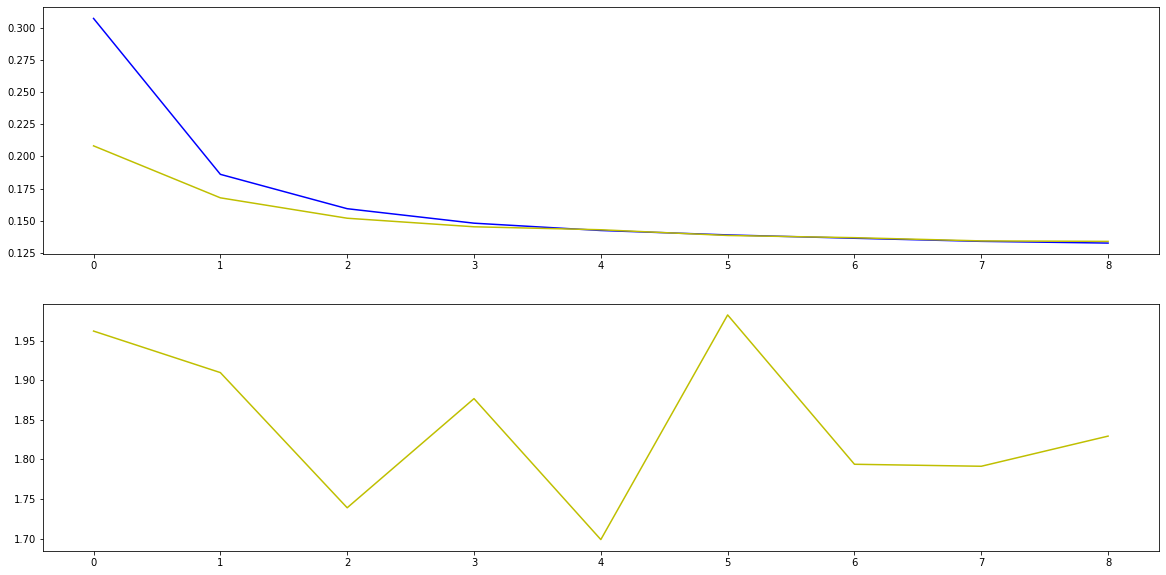

In [65]:
trainer.plot()